In [21]:
import sys
import os
import comet_ml
sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import models.stribor_lib as st

In [23]:
path = "./"
comet_img_path = "./"

# Load Data

In [60]:
data = []
ys = []
num_points = 30
len_data = 20000
for _ in range(len_data):
    x,y = make_moons(n_samples=num_points,noise=0.05,shuffle=True)
    data.append(x)
    ys.append(y)
data = torch.tensor(np.array(data),dtype=torch.float32)
ys = torch.tensor(np.array(ys),dtype=torch.float32)
print(data.shape)

torch.Size([20000, 30, 2])


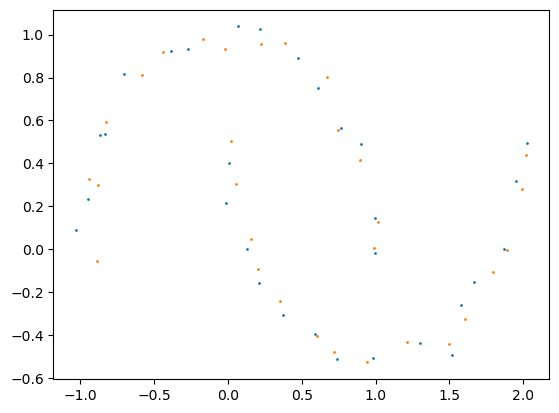

In [61]:
plt.scatter(data[0,:,0],data[0,:,1],s=1)
plt.scatter(data[1,:,0],data[1,:,1],s=1)
plt.show()

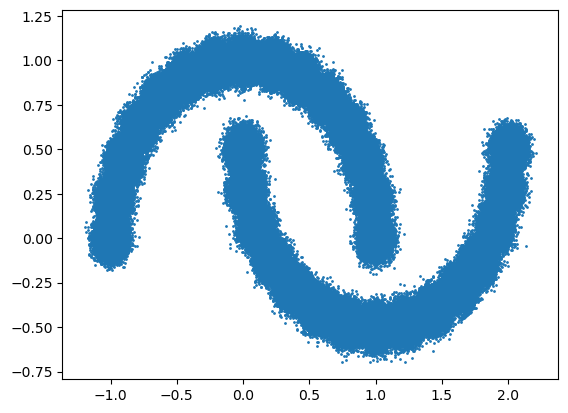

In [62]:
plt.scatter(data[:,:,0],data[:,:,1],s=1)
plt.show()

# Model

In [28]:
device = "cuda"

In [29]:
def get_exact_model(dim, hidden_dims, latent_dim, context_dim=0, n_transforms=4, n_heads=2, model="deepset", set_data=False, device='mps', atol=1e-4, base_dist_mean=None, base_dist_cov=None):
    
    has_latent = True if context_dim > 0 else False
    
    transforms = []
    
    for _ in range(n_transforms):
        
        if model == "deepset":
            net=st.net.DiffeqExactTraceDeepSet(dim, hidden_dims, dim, d_h=latent_dim, latent_dim=context_dim)
        elif model == "settransformer":
            net=st.net.DiffeqExactTraceAttention(dim, hidden_dims, dim, d_h=latent_dim, n_heads=n_heads, latent_dim=context_dim)
        else:
            raise NotImplementedError
            
        transforms.append(st.ContinuousNormalizingFlow(dim, net=net, divergence='exact', solver='dopri5', atol=atol, has_latent=has_latent, set_data=set_data))
        
    if base_dist_mean is None:
        base_dist_mean = torch.zeros(dim)
        
    if base_dist_cov is None:
        base_dist_cov = torch.ones(dim)

    model = st.Flow(st.Normal(base_dist_mean.to(device), base_dist_cov.to(device)), transforms).to(device)
    
    return model

In [30]:

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, CometLogger

from torch.utils.data import TensorDataset, DataLoader, random_split

In [31]:
max_epochs = 5
modeltype="settransformer"
model_name_for_saving=f"{modeltype}1"

In [32]:
class SetFlow(pl.LightningModule):

    def __init__(self, optimizer=torch.optim.AdamW, 
                         optimizer_kwargs={"weight_decay":1e-5}, 
                         lr=8e-4, 
                         scheduler=torch.optim.lr_scheduler.CosineAnnealingLR,
                         scheduler_kwargs = {"T_max":max_epochs}):
        super().__init__()
        
        self.optimizer = optimizer
        self.optimizer_kwargs = optimizer_kwargs
        self.scheduler = scheduler
        self.scheduler_kwargs = scheduler_kwargs
        self.lr = lr
        self.save_hyperparameters()
        self.network = get_exact_model(dim=2, hidden_dims=[64, 64], latent_dim=8, context_dim=0, 
                                       n_transforms=2, n_heads=2, model=modeltype, set_data=True, 
                                       base_dist_mean=None,
                                       base_dist_cov=None, device=device, atol=1e-4)
        
    def loss(self, x, mask):
        log_prob = self.network.log_prob(x, mask=mask) 
        #loss = -(log_prob * mask).sum() / mask.sum()
        loss = -log_prob.sum()
        return loss
        
    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), lr=self.lr, **self.optimizer_kwargs)
        
        return {"optimizer": optimizer, 
                    "lr_scheduler": {
                    "scheduler": self.scheduler(optimizer, **self.scheduler_kwargs),
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 1}
                }
            
    def training_step(self, batch, batch_idx):
        x,y = batch
        #print(f"batch: {type(x)}")
        mask = None
        loss = self.loss(x, mask)     
        self.log('train_loss', loss, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x,y = batch
        mask = None
        loss = self.loss(x, mask)     
        self.log('val_loss', loss, on_epoch=True)
        return loss

In [33]:
batch_size = 256

val_fraction = 0.1
n_samples_val = int(val_fraction * len(data))

dataset = TensorDataset(data,data)

dataset_train, dataset_val = random_split(dataset, [len(data) - n_samples_val, n_samples_val])
#print(f"dataset train: {dataset_train.shape}")
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=False)

In [35]:
model = SetFlow()

In [36]:
def count_parameters(model):
    """Count Parameters of model

    Args:
        model (_type_): model

    Returns:
        parameters _type_: parameters of the model
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [37]:
class EvaluationCallback(pl.Callback):
    def __init__(
        self,
        every_n_epochs=10,
        num_samples=1000,
        points_per_set=50,
        image_path=f"{comet_img_path}comet_logs",
        name=model_name_for_saving,
    ):
        super().__init__()
        self.every_n_epochs = (
            every_n_epochs  # Only save those jets every N epochs to reduce logging
        )
        self.num_samples = num_samples  # Number of jets to generate
        self.points_per_set = points_per_set

        self.name = name
        self.image_path = image_path

    def on_train_epoch_end(self, trainer, pl_module):
        # Skip for all other epochs
        if trainer.current_epoch % self.every_n_epochs == 0:
            plot_name = f"{self.name}-{trainer.current_epoch}"

            samples = (
                pl_module.network.sample(
                    num_samples=(self.num_samples, self.points_per_set)
                )
                .to("cpu")
                .detach()
            )
            plt.scatter(samples[:, :, 0], samples[:, :, 1], s=1)
            plt.savefig(f"{self.image_path}/plots/{plot_name}.png")
            plt.clf()
            
            img_path = f"{self.image_path}/plots/{plot_name}.png"
            trainer.loggers[1].experiment.log_image(
                img_path, name=f"epoch{trainer.current_epoch}"
            )

            # Parameters
            parameters = count_parameters(pl_module)
            trainer.loggers[1].log_hyperparams({"parameters": parameters})
        



In [38]:
comet_logger = CometLogger(
    api_key=os.environ.get("COMET_API_KEY"),
    workspace=os.environ.get("COMET_WORKSPACE"),  # Optional
    save_dir=f"{path}logs/comet/{model_name_for_saving}",  # Optional
    project_name="Jet Setting",  # Optional
    rest_api_key=os.environ.get("COMET_REST_API_KEY"),  # Optional
    experiment_key=os.environ.get("COMET_EXPERIMENT_KEY"),  # Optional
    experiment_name=model_name_for_saving,  # Optional
    offline=False,
)

CometLogger will be initialized in online mode


In [68]:
# Lightning callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    filename=f"{modeltype}-{{epoch:02d}}-{{val_loss:.2f}}",
    every_n_epochs=1,
    save_top_k=3,
    save_last=True,
    dirpath=f"{path}checkpoints/{model_name_for_saving}/",
)
early_stop_callback = EarlyStopping(monitor='val_loss', patience=6)        
lr_monitor = LearningRateMonitor(logging_interval='epoch')
evaluation_callback = EvaluationCallback()
csv_logger = CSVLogger(f"{path}logs", name=model_name_for_saving)
# Instantiate trainer
trainer = pl.Trainer(max_epochs=max_epochs, accelerator='gpu', devices=-1, gradient_clip_val=1., callbacks=[checkpoint_callback, lr_monitor])#, evaluation_callback]),logger=[csv_logger, comet_logger])
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)  


# Continue training
#ckpt = f"{path}checkpoints/settransformer1/last.ckpt"
#trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader, ckpt_path=ckpt)  

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | network | Flow | 45.3 K
---------------------------------
45.3 K    Trainable params
0         Non-trainable params
45.3 K    Total params
0.181     Total estimated model params size (MB)


Epoch 0:  20%|██        | 16/79 [00:14<00:55,  1.14it/s, loss=1.49e+04, v_num=30]

/beegfs/desy/user/ewencedr/conda/envs/jetnetConda/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [50]:
ckpt = f"{path}checkpoints/settransformer0/settransformer-epoch=149-val_loss=1697.71.ckpt"
model = SetFlow.load_from_checkpoint(ckpt)

In [51]:
model.to('cuda')
n_particles = 5000
points_per_set = 30
samples = model.network.sample(num_samples=(n_particles,points_per_set)).to('cpu').detach()

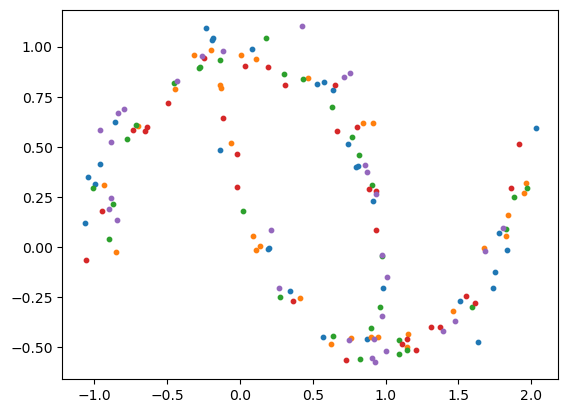

In [69]:
for i in range(5):
    plt.scatter(samples[i,:,0],samples[i,:,1],s=10)
plt.show()


Epoch 140: 100%|██████████| 79/79 [23:31<00:00, 17.87s/it, loss=1.67e+03, v_num=27]


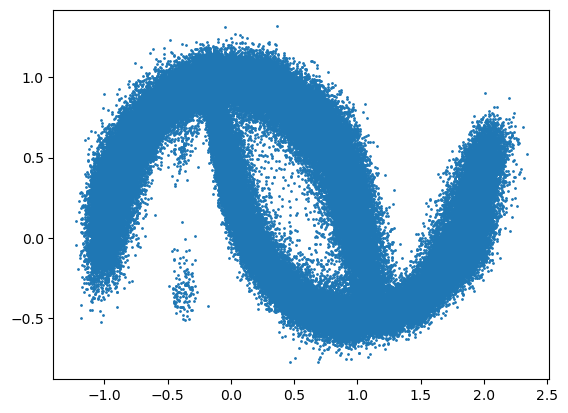

In [56]:
plt.scatter(samples[:,:,0],samples[:,:,1],s=1)
plt.show()
